# Enhance quality of PNG images with auto-encoder



Task here is to build auto-encoder to super impose images to their enhanced quality.

Here I am mounting the drive. This means I have uploaded dataset with images to Google Drive and then connected this Google Colab with my drive. It's must be if I want to use dataset from Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import libraries and utilities

In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras import layers

Load dataset

In [3]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

SIZE = 96
high_img = []
path = '/content/drive/MyDrive/low-res-to-high-res/dataset/HR'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    img = cv2.imread(path + '/'+i,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    high_img.append(tf.keras.preprocessing.image.img_to_array(img))


low_img = []
path = '/content/drive/MyDrive/low-res-to-high-res/dataset/LR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    img = cv2.imread(path + '/'+i,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    low_img.append(tf.keras.preprocessing.image.img_to_array(img))

100%|██████████| 100/100 [00:01<00:00, 76.35it/s]


60 images are in a training dataset. 23 images are in the validation dataset and remaining 16 in test dataset

In [4]:
train_high_image = high_img[:60]
train_low_image = low_img[:60]
train_high_image = np.reshape(train_high_image,(len(train_high_image), SIZE, SIZE,  3))
train_low_image = np.reshape(train_low_image,(len(train_low_image), SIZE, SIZE,  3))

validation_high_image = high_img[60:83]
validation_low_image = low_img[60:83]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image), SIZE, SIZE, 3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image), SIZE, SIZE, 3))

test_high_image = high_img[83:]
test_low_image = low_img[83:]
test_high_image= np.reshape(test_high_image,(len(test_high_image), SIZE, SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image), SIZE, SIZE, 3))

In [5]:
def encoder_without_batch_normalization():

    inputs2 = layers.Input(shape= [SIZE,SIZE,3])

    l1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(inputs2)
    l2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l1)
    l3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l2)
    l4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l3)
    l5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l4)

    l6 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l5)

    l6 = tf.keras.layers.concatenate([l6, l4])

    l7 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l6)

    l7 = tf.keras.layers.concatenate([l7, l3])

    l8 = tf.keras.layers.Conv2DTranspose(128, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l7)
    
    l8 = tf.keras.layers.concatenate([l8, l2])

    l8 = tf.keras.layers.Conv2DTranspose(128, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l8)

    l8 = tf.keras.layers.concatenate([l8, l1])

    l9 = tf.keras.layers.Conv2DTranspose(3, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l8)

    l9 = tf.keras.layers.concatenate([l9, inputs2])

    output = layers.Conv2D(3, (2,2),strides = 1, padding = 'same')(l9)
    return tf.keras.Model(inputs=inputs2, outputs=output)

encoder_without_batch_normalization = encoder_without_batch_normalization()

In [6]:
encoder_without_batch_normalization.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                    loss = 'mean_absolute_error', 
                    metrics = ['acc'])

Model is ready, now we have to compile it. We're going through 15 epochs, number of images in batch is 5.

In [7]:
history_without_batch_norm = encoder_without_batch_normalization.fit(train_low_image, train_high_image, epochs = 15, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/15
60/60 [==============================] - 13s 196ms/step - loss: 0.1476 - acc: 0.4738 - val_loss: 0.0917 - val_acc: 0.5755
Epoch 2/15
60/60 [==============================] - 11s 181ms/step - loss: 0.0860 - acc: 0.5770 - val_loss: 0.0739 - val_acc: 0.6005
Epoch 3/15
60/60 [==============================] - 12s 197ms/step - loss: 0.0751 - acc: 0.5847 - val_loss: 0.0680 - val_acc: 0.5990
Epoch 4/15
60/60 [==============================] - 13s 224ms/step - loss: 0.0675 - acc: 0.6261 - val_loss: 0.0668 - val_acc: 0.5891
Epoch 5/15
60/60 [==============================] - 13s 210ms/step - loss: 0.0649 - acc: 0.6244 - val_loss: 0.0585 - val_acc: 0.6400
Epoch 6/15
60/60 [==============================] - 11s 188ms/step - loss: 0.0600 - acc: 0.6331 - val_loss: 0.0581 - val_acc: 0.6123
Epoch 7/15
60/60 [==============================] - 12s 199ms/step - loss: 0.0556 - acc: 0.6503 - val_loss: 0.0537 - val_acc: 0.6992
Epoch 8/15
60/60 [==============================] - 11s 188ms/step - 

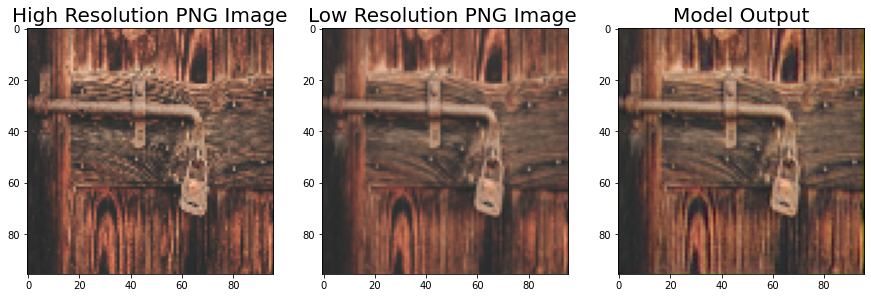

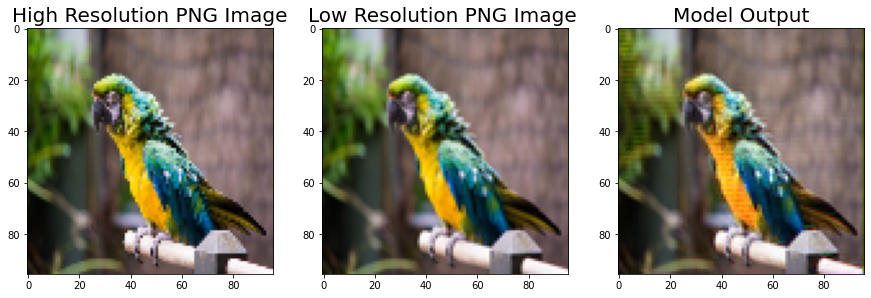

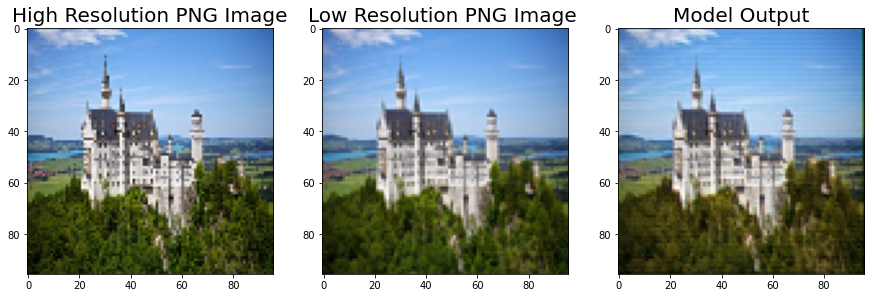

In [8]:
"""
function gets images and displays them side by side for comparison
"""
def show_model_output(hq_image, lq_image, encoder_output):

    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Resolution PNG Image', color = 'black', fontsize = 20)
    plt.imshow(hq_image)
    plt.subplot(1,3,2)
    plt.title('Low Resolution PNG Image ', color = 'black', fontsize = 20)
    plt.imshow(lq_image)
    plt.subplot(1,3,3)
    plt.title('Model Output', color = 'black', fontsize = 20)
    plt.imshow(encoder_output)
    plt.show()

for photo_triple in range(1, 4):
    encoder_output = np.clip(encoder_without_batch_normalization.predict(test_low_image[photo_triple].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE,3)
    show_model_output(test_high_image[photo_triple],test_low_image[photo_triple], encoder_output)

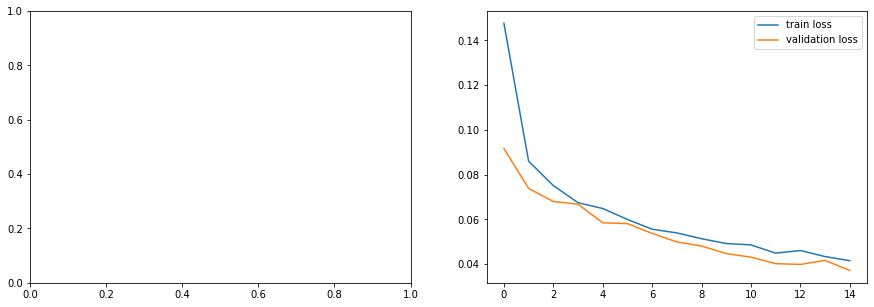

In [9]:
def show_training_loss_in_graph(model_training_history):
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    ax[1].plot(model_training_history.history['loss'], label='train loss')
    ax[1].plot(model_training_history.history['val_loss'], label='validation loss')
    ax[1].legend()

show_training_loss_in_graph(history_without_batch_norm)

Now we're going to build encoder with batch normalization and see if it helps to super impose images.

In [18]:
def conv(filters, kernel_size, apply_batch_normalization = True):
    conv = tf.keras.models.Sequential()
    conv.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2))
    layers.BatchNormalization()
    conv.add(keras.layers.LeakyReLU())
    return conv

def conv2dtransponse(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def encoder_with_batch_normalization():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    
    # same approach as above with exception that we're using batch normalization here
    l1 = conv(128,(3,3),False)(inputs)
    l2 = conv(128,(3,3),False)(l1)
    l3 = conv(256,(3,3),True)(l2)
    l4 = conv(512,(3,3),True)(l3)
    l5 = conv(512,(3,3),True)(l4)

    u1 = conv2dtransponse(512,(3,3),False)(l5)
    u1 = layers.concatenate([u1,l4])
    u2 = conv2dtransponse(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,l3])
    u3 = conv2dtransponse(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,l2])
    u4 = conv2dtransponse(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,l1])
    u5 = conv2dtransponse(128,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    u6 = conv2dtransponse(128,(3,3),False)(u4)
    u6 = layers.concatenate([u5,inputs])
    u7 = conv2dtransponse(128,(3,3),False)(u4)
    u7 = layers.concatenate([u5,inputs])
    u8 = conv2dtransponse(3,(3,3),False)(u4)
    u8 = layers.concatenate([u5,inputs])

    output = layers.Conv2D(3, (2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

encoder_with_batch_normalization = encoder_with_batch_normalization()

In [19]:
encoder_with_batch_normalization.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [20]:
history_with_batch_norm = encoder_with_batch_normalization.fit(train_low_image, train_high_image, epochs = 15, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/15
60/60 [==============================] - 17s 260ms/step - loss: 0.1025 - acc: 0.5475 - val_loss: 0.0537 - val_acc: 0.7049
Epoch 2/15
60/60 [==============================] - 16s 264ms/step - loss: 0.0616 - acc: 0.7373 - val_loss: 0.0596 - val_acc: 0.6661
Epoch 3/15
60/60 [==============================] - 17s 284ms/step - loss: 0.1298 - acc: 0.6929 - val_loss: 1.3515 - val_acc: 0.4413
Epoch 4/15
60/60 [==============================] - 17s 285ms/step - loss: 1.5837 - acc: 0.3621 - val_loss: 0.1305 - val_acc: 0.3433
Epoch 5/15
60/60 [==============================] - 17s 279ms/step - loss: 0.0920 - acc: 0.5378 - val_loss: 0.0596 - val_acc: 0.5966
Epoch 6/15
60/60 [==============================] - 16s 264ms/step - loss: 0.0531 - acc: 0.7262 - val_loss: 0.0475 - val_acc: 0.6946
Epoch 7/15
60/60 [==============================] - 16s 272ms/step - loss: 0.0455 - acc: 0.7674 - val_loss: 0.0403 - val_acc: 0.7795
Epoch 8/15
60/60 [==============================] - 15s 257ms/step - 

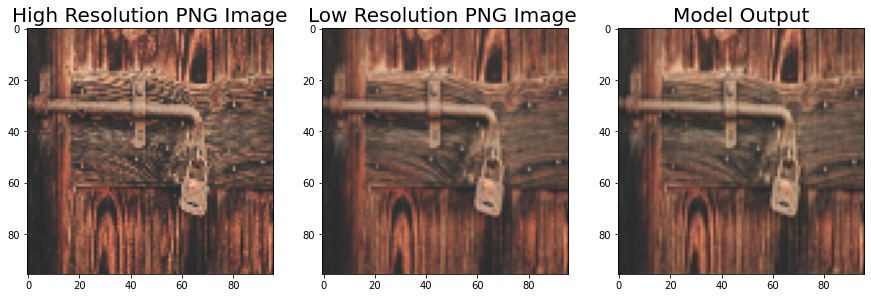

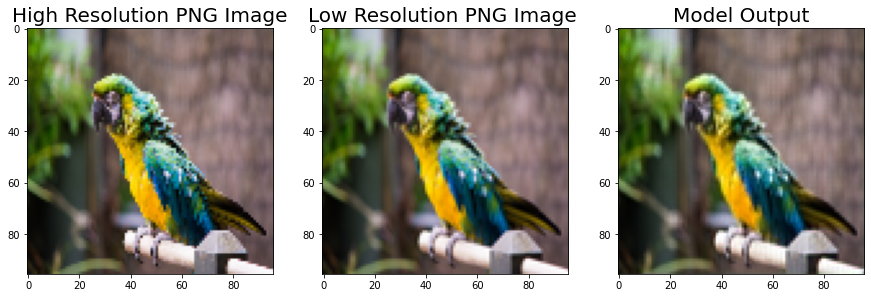

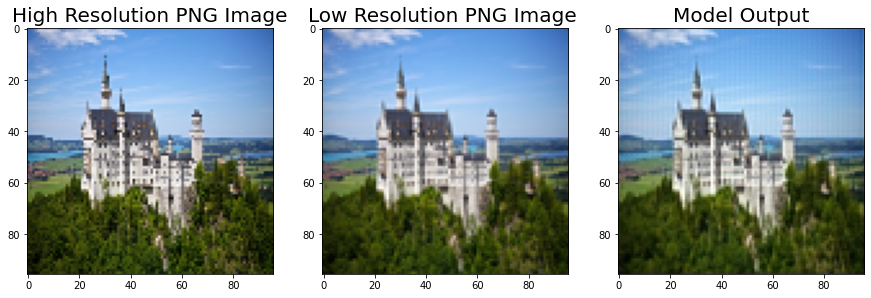

In [21]:
"""
function gets images and displays them side by side for comparison
"""
def show_model_output(hq_image, lq_image, encoder_output):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Resolution PNG Image', color = 'black', fontsize = 20)
    plt.imshow(hq_image)
    plt.subplot(1,3,2)
    plt.title('Low Resolution PNG Image ', color = 'black', fontsize = 20)
    plt.imshow(lq_image)
    plt.subplot(1,3,3)
    plt.title('Model Output', color = 'black', fontsize = 20)
    plt.imshow(encoder_output)
    plt.show()

for photo_triple in range(1, 4):
    encoder_output = np.clip(encoder_with_batch_normalization.predict(test_low_image[photo_triple].reshape(1, SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    show_model_output(test_high_image[photo_triple],test_low_image[photo_triple], encoder_output)

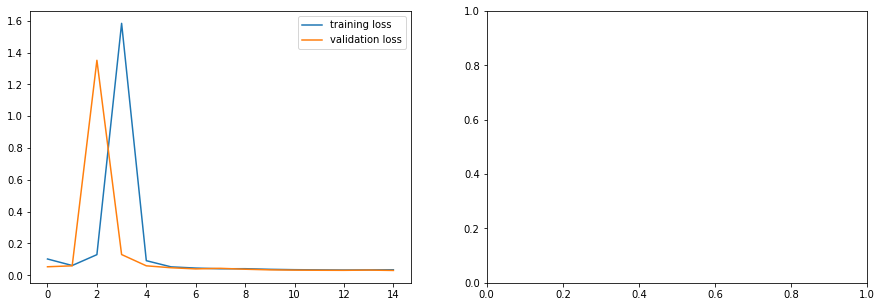

In [22]:
def show_training_loss_in_graph(model_training_history):
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    ax[0].plot(model_training_history.history['loss'], label='training loss')
    ax[0].plot(model_training_history.history['val_loss'], label='validation loss')
    ax[0].legend()
    
show_training_loss_in_graph(history_with_batch_norm)